In [2]:
import torch
from scipy.optimize import brentq,root_scalar
import scipy.stats as st
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [3]:
corruptions = ['gaussian_noise','impulse_noise','shot_noise','defocus_blur','glass_blur','motion_blur','zoom_blur','snow','frost','fog','brightness','contrast','elastic_transform','jpeg_compression','pixelate']
# load the confidence scores
clean_embds,clean_labels,clean_preds = torch.load("../continual_learning/continual_learning_playground/src/test_time_kd/embds/clean224.pt")
clean_embds128,clean_labels128,clean_preds128 = torch.load("../continual_learning/continual_learning_playground/src/test_time_kd/embds/clean128.pt")
corr_embds = []
corr_labels = []
corr_preds = []
corr_embds128 = []
corr_labels128 = []
corr_preds128 = []
corr_embds64 = []
corr_labels64 = []
corr_preds64 = []
for i,corr in enumerate(corruptions):
    e,l,p = torch.load("../continual_learning/continual_learning_playground/src/test_time_kd/embds/corr224_"+corr+".pt")
    e128,l128,p128 = torch.load("../continual_learning/continual_learning_playground/src/test_time_kd/embds/corr128_"+corr+".pt")
    # e64,l64,p64 = torch.load("embds/corr64_"+corr+".pt")
    corr_embds.append(e)
    corr_labels.append(l)
    corr_preds.append(p)
    corr_embds128.append(e128)
    corr_labels128.append(l128)
    corr_preds128.append(p128)

setup parameters

In [32]:
n = 1000
alphas = [0.05,0.15,0.25]
rand_idxs = torch.randperm(50000)
rand_corr_order = torch.randperm(15)
cal_idxs = rand_idxs[:n]
val_idxs = rand_idxs[n:]

initial calibration

In [33]:
student_confs,student_decs = torch.max(clean_preds128,dim=1)
teacher_confs,teacher_decs = torch.max(clean_preds,dim=1)

student_cal_scores = student_confs[cal_idxs]
student_cal_preds = student_decs[cal_idxs]
teacher_cal_preds = teacher_decs[cal_idxs]

lambda_hats = []
mean_stud_uses = []

for i,alpha in enumerate(alphas):

    # zero-one loss
    def zo_loss(p_pred_set,t_pred_set):
        return (p_pred_set != t_pred_set).float().mean()

    # the lambda hat threshold, we want the largest lambda hat that we satisfy the condition
    def lamhat_threshold(lam): 
        p_set = (student_cal_scores >= lam)*student_cal_preds + (student_cal_scores < lam)*teacher_cal_preds
        return zo_loss(p_set, teacher_cal_preds) - ((n+1)/n*alpha - 1/(n+1))

    lambda_hats.append(brentq(lamhat_threshold, 0, 1))

    mean = (student_cal_scores >= lambda_hats[i]).float().mean()
    std = (student_cal_scores >= lambda_hats[i]).float().std()
    lower = mean-st.norm.ppf(1-(0.05)/2)*(std/np.sqrt(len(student_cal_preds)))
    upper = mean+st.norm.ppf(1-(0.05)/2)*(std/np.sqrt(len(student_cal_preds)))
    lower = lower + (1-lower)*10
    upper = upper + (1-upper)*10
    mean_stud_uses.append([lower,upper])

testing
* 49000 test points
    * 4000 clean, 3000 per corruption
* store average risk, acc, and cost over last 1000

In [34]:
# store running stats
policy_dec = torch.zeros((len(alphas),len(val_idxs)),dtype=int)
policy_pred = torch.zeros((len(alphas),len(val_idxs)),dtype=int)
student_pred = torch.zeros(len(val_idxs),dtype=int)
teacher_pred = torch.zeros(len(val_idxs),dtype=int)

policy_dec_clean = torch.zeros((len(alphas),len(val_idxs)),dtype=int)
policy_pred_clean = torch.zeros((len(alphas),len(val_idxs)),dtype=int)
student_pred_clean = torch.zeros(len(val_idxs),dtype=int)
teacher_pred_clean = torch.zeros(len(val_idxs),dtype=int)

# clean predictions
student_val_scores = student_confs[val_idxs]
student_val_preds = student_decs[val_idxs]
teacher_val_preds = teacher_decs[val_idxs]

# try three different alphas
for alpha_i,alpha in enumerate(alphas):
    # get decision for clean samples (1 = student, 0 = teacher)
    policy_dec[alpha_i,:4000] = (student_val_scores[:4000] >= lambda_hats[alpha_i])
    policy_pred[alpha_i,:4000] = (student_val_scores[:4000] >= lambda_hats[alpha_i])*student_val_preds[:4000] + \
                                 (student_val_scores[:4000] < lambda_hats[alpha_i])*teacher_val_preds[:4000]
    student_pred[:4000] = student_val_preds[:4000]
    teacher_pred[:4000] = teacher_val_preds[:4000]

    policy_dec_clean[alpha_i,:] = (student_val_scores[:] >= lambda_hats[alpha_i])
    policy_pred_clean[alpha_i,:] = (student_val_scores[:] >= lambda_hats[alpha_i])*student_val_preds[:] + \
                                 (student_val_scores[:] < lambda_hats[alpha_i])*teacher_val_preds[:]
    student_pred_clean[:] = student_val_preds[:]
    teacher_pred_clean[:] = teacher_val_preds[:]

    # get decision for each corruption
    for corr_i,corruption in enumerate(corruptions):
        student_confs_,student_decs_ = torch.max(corr_preds128[rand_corr_order[corr_i]],dim=1)
        teacher_confs_,teacher_decs_ = torch.max(corr_preds[rand_corr_order[corr_i]],dim=1)

        student_val_scores_ = student_confs_[val_idxs]
        student_val_preds_ = student_decs_[val_idxs]
        teacher_val_preds_ = teacher_decs_[val_idxs]

        # get decision for corrupt samples (1 = student, 0 = teacher)
        start = 4000+corr_i*3000
        stop = 4000+(corr_i+1)*3000
        policy_dec[alpha_i,start:stop] = (student_val_scores_[start:stop] >= lambda_hats[alpha_i])
        policy_pred[alpha_i,start:stop] = (student_val_scores_[start:stop] >= lambda_hats[alpha_i])*student_val_preds_[start:stop] + \
                                          (student_val_scores_[start:stop] < lambda_hats[alpha_i])*teacher_val_preds_[start:stop]
        student_pred[start:stop] = student_val_preds_[start:stop]
        teacher_pred[start:stop] = teacher_val_preds_[start:stop]

get the stats

In [42]:
local_avg_risk = torch.zeros((len(alphas),len(val_idxs)))
local_avg_acc = torch.zeros((len(alphas),len(val_idxs)))
local_avg_acc_t = torch.zeros(len(val_idxs))
local_avg_cost = torch.zeros((len(alphas),len(val_idxs)))
avg_risk = torch.zeros(len(alphas))
avg_acc = torch.zeros(len(alphas))
avg_acc_t = 0
avg_cost = torch.zeros(len(alphas))

local_avg_risk_clean = torch.zeros((len(alphas),len(val_idxs)))
local_avg_acc_clean = torch.zeros((len(alphas),len(val_idxs)))
local_avg_acc_t_clean = torch.zeros(len(val_idxs))
local_avg_cost_clean = torch.zeros((len(alphas),len(val_idxs)))
avg_risk_clean = torch.zeros(len(alphas))
avg_acc_clean = torch.zeros(len(alphas))
avg_acc_t_clean = 0
avg_cost_clean = torch.zeros(len(alphas))
bern_local = torch.zeros((len(alphas),len(val_idxs)))
bern = torch.rand(49000)

window_size = 1000
gt_val = corr_labels[0][val_idxs]

for idx,sample in enumerate(tqdm(policy_dec[0])):
    start = 0 if idx <= window_size else idx - window_size
    stop = idx+1
    for alpha_i,alpha in enumerate(alphas):
        local_avg_risk[alpha_i,idx] = (policy_pred[alpha_i,start:stop] != teacher_pred[start:stop]).float().mean()
        local_avg_acc[alpha_i,idx] = (policy_pred[alpha_i,start:stop] == gt_val[start:stop]).float().mean()
        local_avg_acc_t[idx] = (teacher_pred[start:stop] == gt_val[start:stop]).float().mean()
        local_avg_cost[alpha_i,idx] = ((policy_dec[alpha_i,start:stop] == 1)*1 + (policy_dec[alpha_i,start:stop] == 0)*10).float().mean()

        local_avg_risk_clean[alpha_i,idx] = (policy_pred_clean[alpha_i,start:stop] != teacher_pred_clean[start:stop]).float().mean()
        local_avg_acc_clean[alpha_i,idx] = (policy_pred_clean[alpha_i,start:stop] == gt_val[start:stop]).float().mean()
        local_avg_acc_t_clean[idx] = (teacher_pred_clean[start:stop] == gt_val[start:stop]).float().mean()
        local_avg_cost_clean[alpha_i,idx] = ((policy_dec_clean[alpha_i,start:stop] == 1)*1 + (policy_dec_clean[alpha_i,start:stop] == 0)*10).float().mean()

        bern_local[alpha_i,idx] = ((bern < alpha)[start:stop]).float().mean()

for alpha_i,alpha in enumerate(alphas):
    avg_risk[alpha_i] = (policy_pred[alpha_i,:] != teacher_pred[:]).float().mean()
    avg_acc[alpha_i] = (policy_pred[alpha_i,:] == gt_val[:]).float().mean()
    avg_acc_t = (teacher_pred[:] == gt_val[:]).float().mean()
    avg_cost[alpha_i] = ((policy_dec[alpha_i,:] == 1)*1 + (policy_dec[alpha_i,:] == 0)*10).float().mean()

    avg_risk_clean[alpha_i] = (policy_pred_clean[alpha_i,:] != teacher_pred_clean[:]).float().mean()
    avg_acc_clean[alpha_i] = (policy_pred_clean[alpha_i,:] == gt_val[:]).float().mean()
    avg_acc_t_clean = (teacher_pred_clean[:] == gt_val[:]).float().mean()
    avg_cost_clean[alpha_i] = ((policy_dec_clean[alpha_i,:] == 1)*1 + (policy_dec_clean[alpha_i,:] == 0)*10).float().mean()

100%|██████████| 49000/49000 [00:26<00:00, 1857.50it/s]


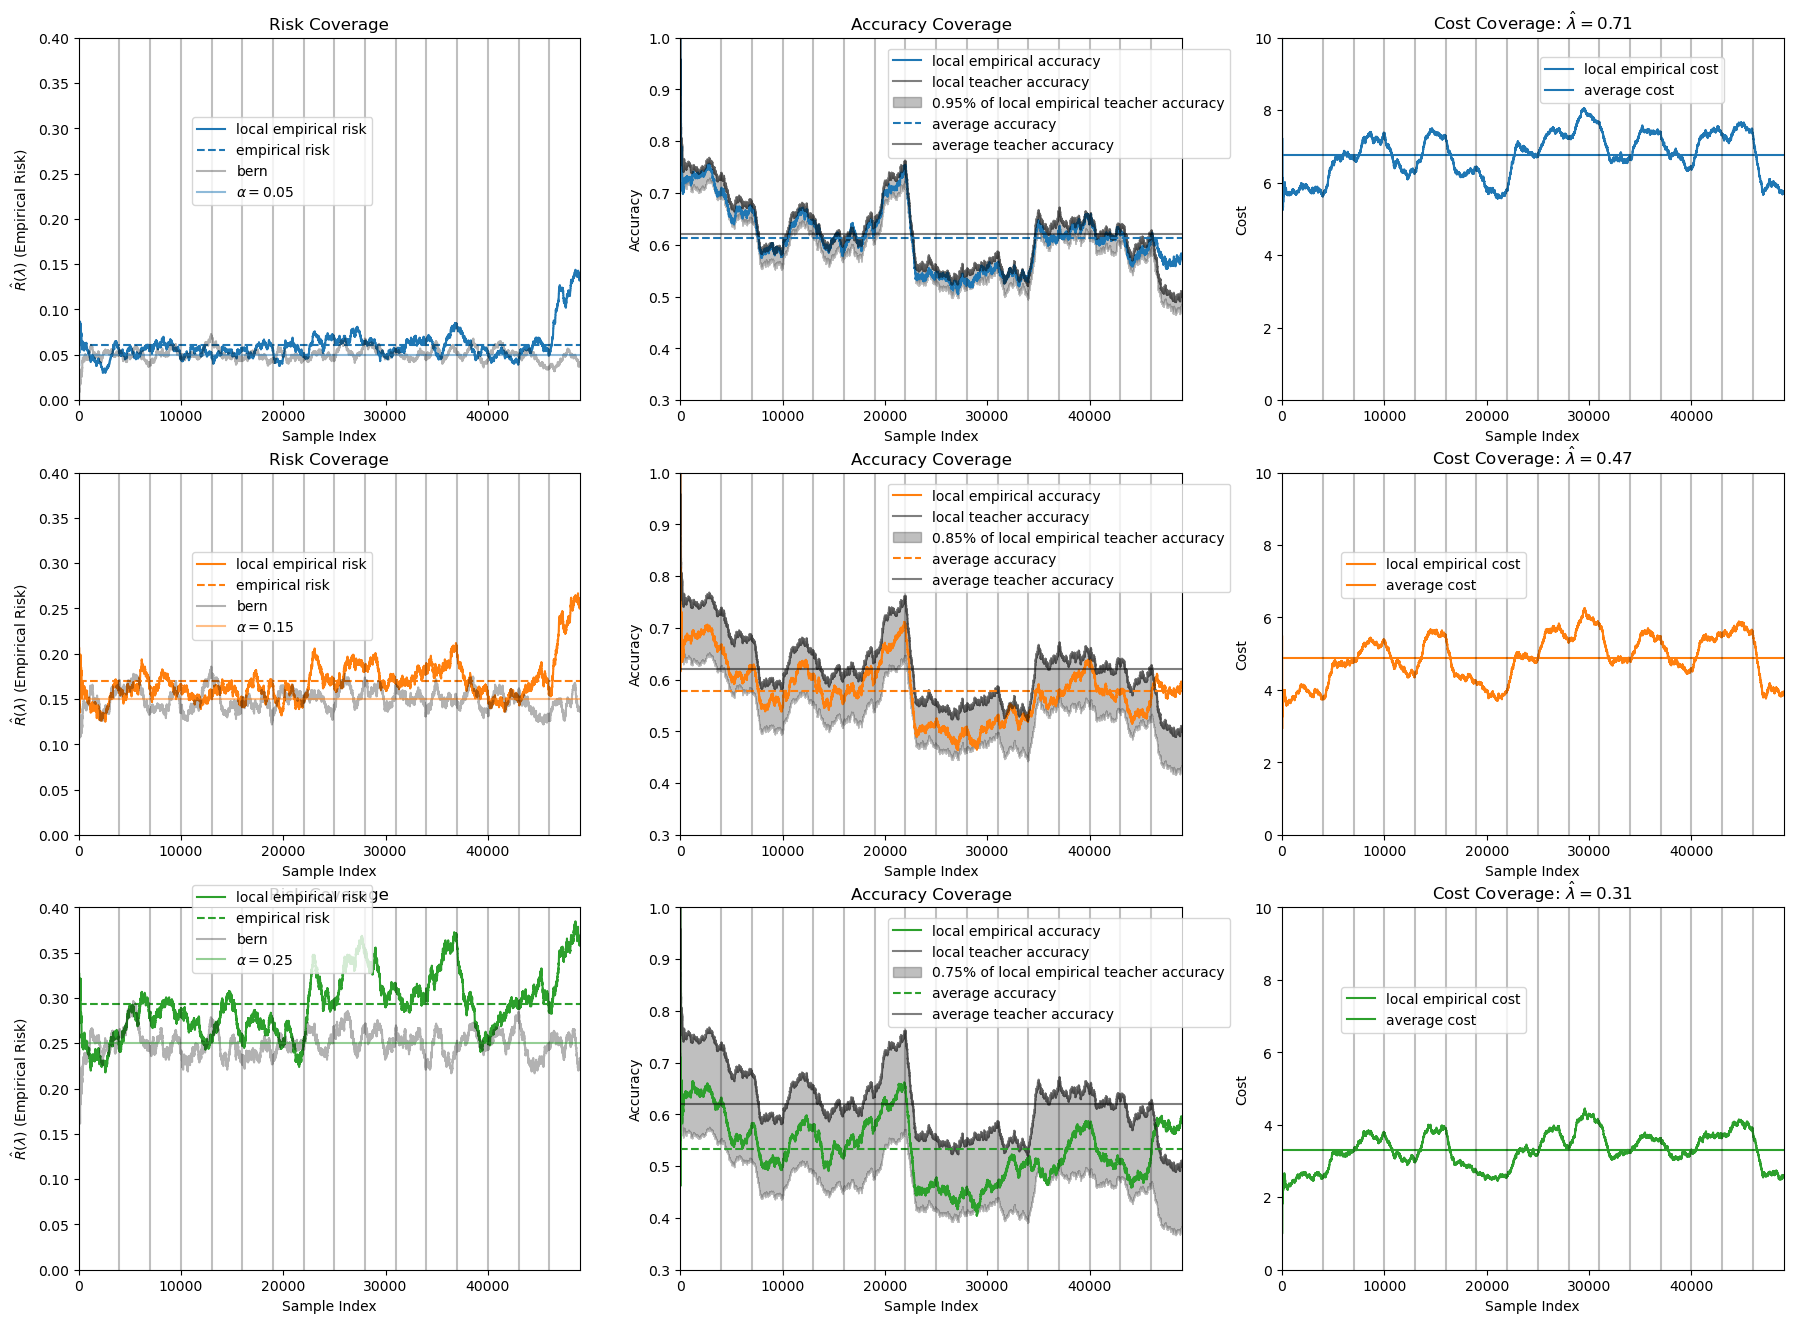

In [49]:
fig, ax = plt.subplots(3,3,figsize=(22,16))
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for alpha_i,alpha in enumerate(alphas):
    # risk
    ax[alpha_i,0].plot(torch.arange(0,len(val_idxs)),local_avg_risk[alpha_i,:],c=cycle[alpha_i],label="local empirical risk")
    ax[alpha_i,0].axhline(avg_risk[alpha_i],c=cycle[alpha_i],linestyle="--",label="empirical risk")
    ax[alpha_i,0].plot(torch.arange(0,len(val_idxs)),bern_local[alpha_i,:],c='k',alpha=0.3,label="bern")
    ax[alpha_i,0].axhline(alpha,c=cycle[alpha_i],label=r'$\alpha=$'+str(alpha),alpha=0.5)
    ax[alpha_i,0].set_title("Risk Coverage")
    ax[alpha_i,0].set_xlabel("Sample Index")
    ax[alpha_i,0].set_ylabel(r'$\hat{R}(\lambda)$ (Empirical Risk)')
    for i in range(15):
        ax[alpha_i,0].axvline(4000+i*3000,c='k',alpha=0.25)
    ax[alpha_i,0].set_xlim([0,49000])
    ax[alpha_i,0].set_ylim([0,0.4])
    # accuracy
    ax[alpha_i,1].plot(torch.arange(0,len(val_idxs)),local_avg_acc[alpha_i,:],c=cycle[alpha_i],label="local empirical accuracy")
    ax[alpha_i,1].plot(torch.arange(0,len(val_idxs)),local_avg_acc_t[:],c='k',label="local teacher accuracy",alpha=0.5)
    ax[alpha_i,1].fill_between(torch.arange(0,len(val_idxs)),(1-alpha)*local_avg_acc_t,local_avg_acc_t,color='k',alpha=0.25,label=str(1-alpha)+"% of local empirical teacher accuracy")
    ax[alpha_i,1].axhline(avg_acc[alpha_i],c=cycle[alpha_i],linestyle="--",label="average accuracy")
    ax[alpha_i,1].axhline(avg_acc_t,c='k',alpha=0.5,label="average teacher accuracy")
    ax[alpha_i,1].set_title("Accuracy Coverage")
    ax[alpha_i,1].set_xlabel("Sample Index")
    ax[alpha_i,1].set_ylabel("Accuracy")
    for i in range(15):
        ax[alpha_i,1].axvline(4000+i*3000,c='k',alpha=0.25)
    ax[alpha_i,1].set_xlim([0,49000])
    ax[alpha_i,1].set_ylim([0.3,1])
    # maybe add fill between on total average?
    # cost
    ax[alpha_i,2].plot(torch.arange(0,len(val_idxs)),local_avg_cost[alpha_i,:],c=cycle[alpha_i],label="local empirical cost")
    ax[alpha_i,2].axhline(avg_cost[alpha_i],c=cycle[alpha_i],label="average cost")
    # ax[alpha_i,2].axhline(sum(mean_stud_uses[alpha_i])/2,c=cycle[alpha_i],linestyle="--",label="predicted cost")
    # ax[alpha_i,2].fill_between(torch.arange(0,len(val_idxs)),torch.ones(len(val_idxs))*mean_stud_uses[alpha_i][0],torch.ones(len(val_idxs))*mean_stud_uses[alpha_i][1],color=cycle[alpha_i],alpha=0.25)
    ax[alpha_i,2].set_title(r'Cost Coverage: $\hat{\lambda}=$'+str(round(lambda_hats[alpha_i],2)))
    ax[alpha_i,2].set_xlabel("Sample Index")
    ax[alpha_i,2].set_ylabel("Cost")
    ax[alpha_i,2].set_ylim([0,10])
    ax[alpha_i,2].set_xlim([0,49000])
    for i in range(15):
        ax[alpha_i,2].axvline(4000+i*3000,c='k',alpha=0.25)

    ax[alpha_i,0].legend(bbox_to_anchor=(0.6,0.8))
    ax[alpha_i,1].legend(bbox_to_anchor=(0.4,0.65))
    ax[alpha_i,2].legend(bbox_to_anchor=(0.5,0.8))


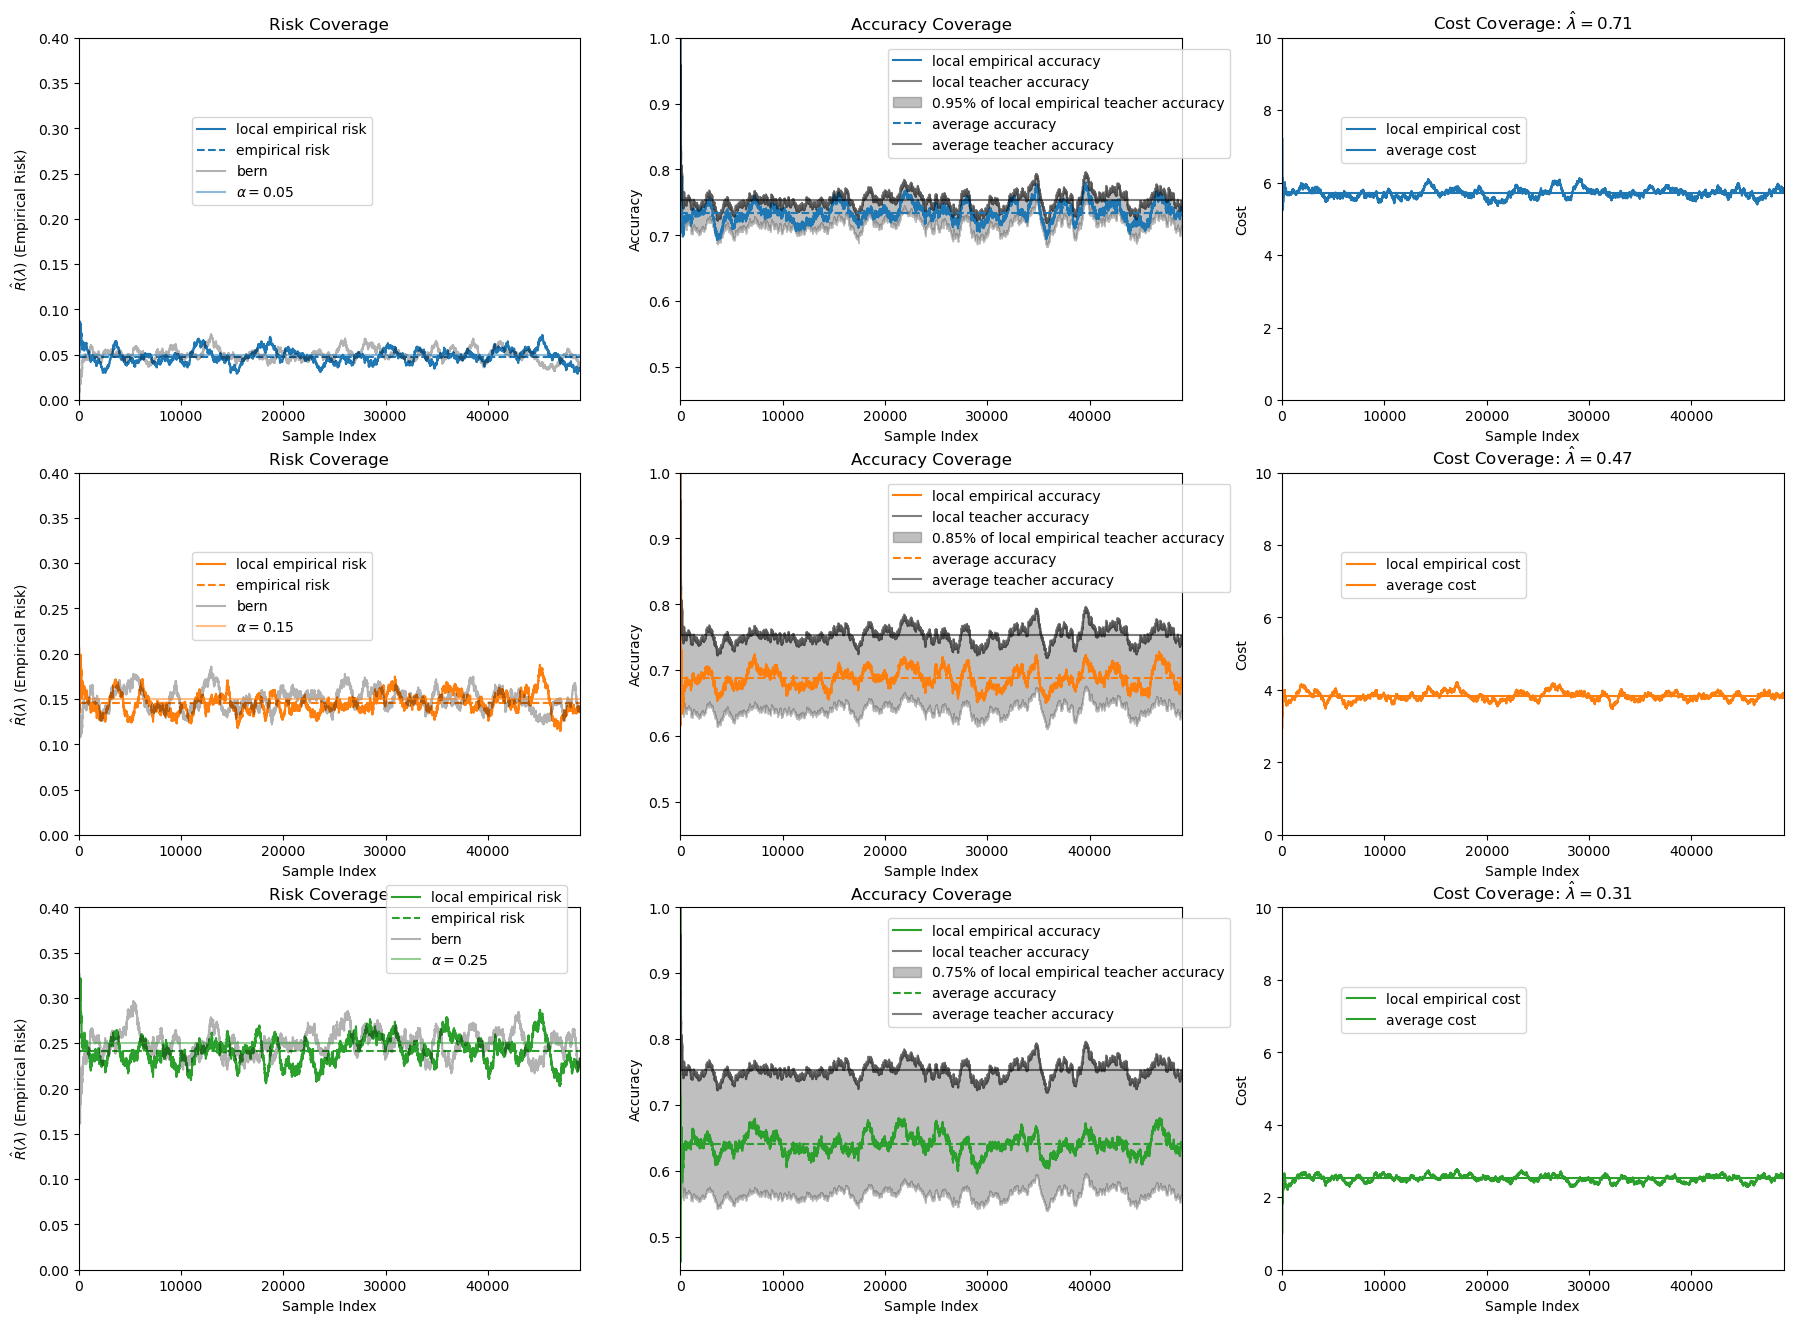

In [48]:
fig, ax = plt.subplots(3,3,figsize=(22,16))
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for alpha_i,alpha in enumerate(alphas):
    # risk
    ax[alpha_i,0].plot(torch.arange(0,len(val_idxs)),local_avg_risk_clean[alpha_i,:],c=cycle[alpha_i],label="local empirical risk")
    ax[alpha_i,0].axhline(avg_risk_clean[alpha_i],c=cycle[alpha_i],linestyle="--",label="empirical risk")
    ax[alpha_i,0].plot(torch.arange(0,len(val_idxs)),bern_local[alpha_i,:],c='k',alpha=0.3,label="bern")
    ax[alpha_i,0].axhline(alpha,c=cycle[alpha_i],label=r'$\alpha=$'+str(alpha),alpha=0.5)
    ax[alpha_i,0].set_title("Risk Coverage")
    ax[alpha_i,0].set_xlabel("Sample Index")
    ax[alpha_i,0].set_ylabel(r'$\hat{R}(\lambda)$ (Empirical Risk)')
    ax[alpha_i,0].set_xlim([0,49000])
    ax[alpha_i,0].set_ylim([0,0.4])

    # accuracy
    ax[alpha_i,1].plot(torch.arange(0,len(val_idxs)),local_avg_acc_clean[alpha_i,:],c=cycle[alpha_i],label="local empirical accuracy")
    ax[alpha_i,1].plot(torch.arange(0,len(val_idxs)),local_avg_acc_t_clean[:],c='k',label="local teacher accuracy",alpha=0.5)
    ax[alpha_i,1].fill_between(torch.arange(0,len(val_idxs)),(1-alpha)*local_avg_acc_t_clean,local_avg_acc_t_clean,color='k',alpha=0.25,label=str(1-alpha)+"% of local empirical teacher accuracy")
    ax[alpha_i,1].axhline(avg_acc_clean[alpha_i],c=cycle[alpha_i],linestyle="--",label="average accuracy")
    ax[alpha_i,1].axhline(avg_acc_t_clean,c='k',alpha=0.5,label="average teacher accuracy")
    ax[alpha_i,1].set_title("Accuracy Coverage")
    ax[alpha_i,1].set_xlabel("Sample Index")
    ax[alpha_i,1].set_ylabel("Accuracy")
    ax[alpha_i,1].set_xlim([0,49000])
    ax[alpha_i,1].set_ylim([0.45,1])
    # maybe add fill between on total average?
    # cost
    ax[alpha_i,2].plot(torch.arange(0,len(val_idxs)),local_avg_cost_clean[alpha_i,:],c=cycle[alpha_i],label="local empirical cost")
    ax[alpha_i,2].axhline(avg_cost_clean[alpha_i],c=cycle[alpha_i],label="average cost")
    # ax[alpha_i,2].axhline(sum(mean_stud_uses[alpha_i])/2,c=cycle[alpha_i],linestyle="--",label="predicted cost")
    # ax[alpha_i,2].fill_between(torch.arange(0,len(val_idxs)),torch.ones(len(val_idxs))*mean_stud_uses[alpha_i][0],torch.ones(len(val_idxs))*mean_stud_uses[alpha_i][1],color=cycle[alpha_i],alpha=0.25)
    ax[alpha_i,2].set_title(r'Cost Coverage: $\hat{\lambda}=$'+str(round(lambda_hats[alpha_i],2)))
    ax[alpha_i,2].set_xlabel("Sample Index")
    ax[alpha_i,2].set_ylabel("Cost")
    ax[alpha_i,2].set_ylim([0,10])
    ax[alpha_i,2].set_xlim([0,49000])

    ax[alpha_i,0].legend(bbox_to_anchor=(0.6,0.8))
    ax[alpha_i,1].legend(bbox_to_anchor=(0.4,0.65))
    ax[alpha_i,2].legend(bbox_to_anchor=(0.5,0.8))